Step 1: Preprocessing Data
Before cleaning:
Shape of data: (668, 1)
Missing values: Tweet    0
dtype: int64
Duplicated rows: 61
After cleaning:
Shape of data: (607, 1)
Missing values: Tweet    0
dtype: int64
Duplicated rows: 0


Device set to use mps:0


Sentiment analysis completed.
Total URLs removed during cleaning: 64
Total mentions removed: 532
Total hashtags removed: 227
Total non-alphabetic characters removed: 3595
                                               Tweet sentiment  \
0  @dgv1133 @KubaBielamowicz Albanians are secula...  NEGATIVE   
1  @E_Z1919 @kos_data Yes. Thank you for remindin...  POSITIVE   
2  @DD_Geopolitics In the name of the only God fo...  NEGATIVE   
3  🇺🇸 #XRP Rewards is live!\n\n1️⃣ Explore Ripple...  POSITIVE   
4  @AbsoluX789 @kirawontmiss Yea but he called Ko...  NEGATIVE   

                                          clean_text  
0  albanians are secular people religion doesnt m...  
1  yes thank you for reminding us of the  fact th...  
2  in the name of the only god for my holy orthod...  
3  rewards is live\n\n explore ripples post \n ch...  
4       yea but he called kosovo a serbian territory  
Shape of data after removing URLs: (607, 3)
Text cleaning completed.
Step 2: Detecting Bias
Bias detec

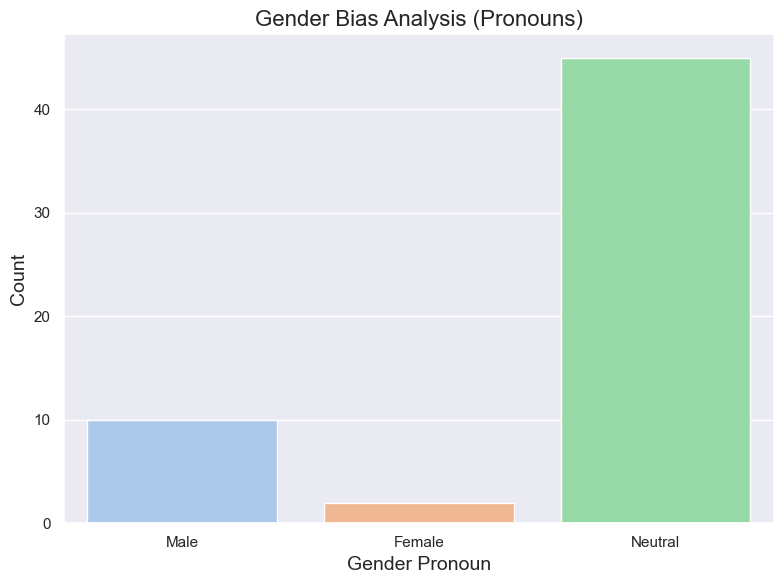

Visualizing racial term usage frequency...


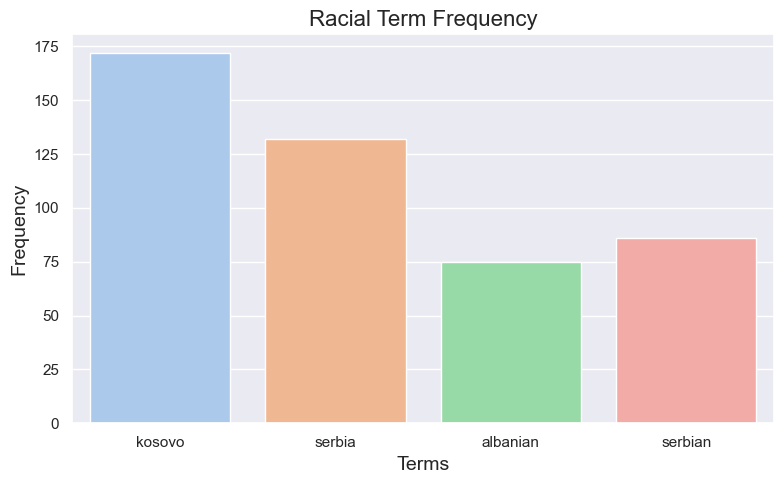

Visualizing conflict vs peace balance distribution...


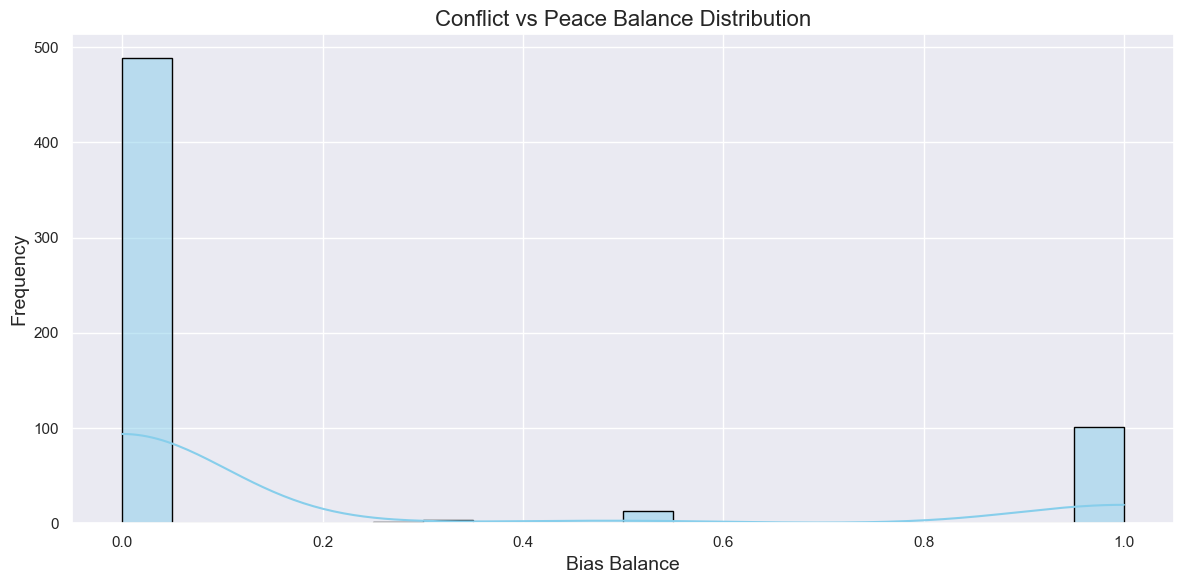

Visualizing sentiment distribution...


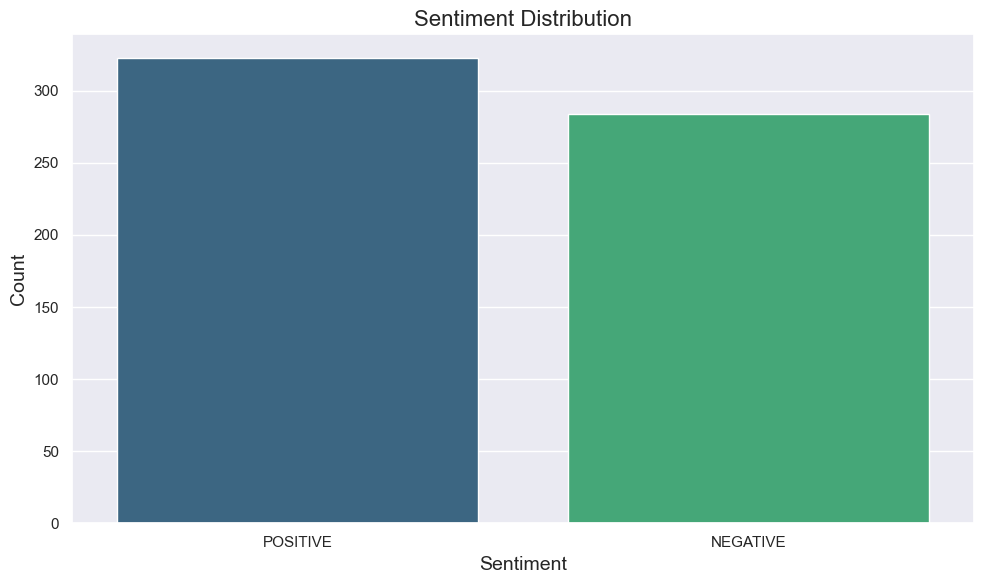

Step 6: Evaluating Model
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.77      0.76        57
           1       0.79      0.77      0.78        65

    accuracy                           0.77       122
   macro avg       0.77      0.77      0.77       122
weighted avg       0.77      0.77      0.77       122

Accuracy: 0.7704918032786885
Analysis exported to output/ethics_bias_analytics.csv


In [11]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from transformers import pipeline
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)

class EthicalBiasDetection:
    def __init__(self, tweets_df):
        self.tweets_df = tweets_df
        self.urls_removed = 0  # Initialize counter for URLs removed
        self.mentions_removed = 0  # Initialize counter for mentions removed
        self.hashtags_removed = 0  # Initialize counter for hashtags removed
        self.non_alphabetic_removed = 0  # Initialize counter for non-alphabetic characters removed

    def _remove_urls_and_special_chars(self, text):
        # Track and count URLs removed
        url_pattern = r'https?://\S+|www\.\S+'
        urls = re.findall(url_pattern, text)
        self.urls_removed += len(urls)  # Increment counter by number of URLs found

        # Track and count mentions
        mentions = re.findall(r'@\w+', text)
        self.mentions_removed += len(mentions)  # Increment counter by number of mentions found
        
        # Track and count hashtags
        hashtags = re.findall(r'#\w+', text)
        self.hashtags_removed += len(hashtags)  # Increment counter by number of hashtags found
        
        # Track and count non-alphabetic characters
        non_alphabetic = re.findall(r'[^a-zA-Z\s]', text)
        self.non_alphabetic_removed += len(non_alphabetic)  # Increment counter by number of non-alphabetic characters found

        # Remove URLs, mentions, hashtags, and non-alphabetic characters
        text = re.sub(url_pattern, '', text)
        text = re.sub(r'@\w+|#\w+', '', text)  # Remove mentions and hashtags
        text = re.sub(r'[^a-zA-Z\s]', '', text.lower())  # Remove non-alphabetic characters
        return text.strip()

    def preprocess_data(self):
        print("Step 1: Preprocessing Data")
        print("Before cleaning:")
        print(f"Shape of data: {self.tweets_df.shape}")
        print(f"Missing values: {self.tweets_df.isnull().sum()}")
        print(f"Duplicated rows: {self.tweets_df.duplicated().sum()}")

        # Drop missing and duplicate values
        self.tweets_df.dropna(subset=['Tweet'], inplace=True)
        self.tweets_df.drop_duplicates(subset=['Tweet'], inplace=True)

        print("After cleaning:")
        print(f"Shape of data: {self.tweets_df.shape}")
        print(f"Missing values: {self.tweets_df.isnull().sum()}")
        print(f"Duplicated rows: {self.tweets_df.duplicated().sum()}")

        # Sentiment analysis using Huggingface pipeline
        sentiment_pipeline = pipeline('sentiment-analysis', model='distilbert/distilbert-base-uncased-finetuned-sst-2-english')
        self.tweets_df['sentiment'] = self.tweets_df['Tweet'].apply(lambda x: sentiment_pipeline(x)[0]['label'])
        print("Sentiment analysis completed.")

        # Clean text
        self.tweets_df['clean_text'] = self.tweets_df['Tweet'].apply(self._remove_urls_and_special_chars)
        print(f"Total URLs removed during cleaning: {self.urls_removed}")
        print(f"Total mentions removed: {self.mentions_removed}")
        print(f"Total hashtags removed: {self.hashtags_removed}")
        print(f"Total non-alphabetic characters removed: {self.non_alphabetic_removed}")
        print(self.tweets_df.head(5))
        print(f"Shape of data after removing URLs: {self.tweets_df.shape}")
        print("Text cleaning completed.")

    def detect_bias(self):
        print("Step 2: Detecting Bias")
        if 'clean_text' not in self.tweets_df.columns:
            raise KeyError("The DataFrame must contain a 'clean_text' column.")
    
        vectorizer = CountVectorizer(stop_words='english')
        term_matrix = vectorizer.fit_transform(self.tweets_df['clean_text'])
        
        # Gender pronouns to search for
        gender_pronouns = {'male': ['he', 'his', 'him'], 'female': ['she', 'her', 'hers'], 'neutral': ['they', 'their', 'them']}
        
        # Initialize counters
        gender_bias_counts = {'male': 0, 'female': 0, 'neutral': 0}
        
        # Iterate over the tweets and count gender pronouns
        for tweet in self.tweets_df['clean_text']:
            for gender, pronouns in gender_pronouns.items():
                for pronoun in pronouns:
                    gender_bias_counts[gender] += tweet.count(pronoun)
    
        print("Bias detected in pronoun usage:")
        print(gender_bias_counts)
        
        # Political bias detection (count occurrences for each term)
        political_terms = ['democrat', 'republic', 'liberal', 'conservative', 'capitalism', 'socialism']
        political_bias_counts = {term: 0 for term in political_terms}
        
        # Count occurrences of each political term in the clean text
        for tweet in self.tweets_df['clean_text']:
            for term in political_terms:
                political_bias_counts[term] += tweet.count(term)
    
        print("Bias detected in political term usage:")
        print(political_bias_counts)
    
        # Racial bias detection (same as before)
        racial_terms = {'kosovo': ['kosovo', 'albanian', 'albanians'], 'serbia': ['serbia', 'serbian', 'serbs'], 'conflict-related': ['ethnic', 'minority', 'majority', 'war']}
        racial_bias_counts = {}
        for race, terms in racial_terms.items():
            term_indices = [vectorizer.vocabulary_.get(term) for term in terms if term in vectorizer.vocabulary_]
            term_counts = term_matrix[:, term_indices].sum(axis=1)
            racial_bias_counts[race] = term_counts.sum()
    
        print("Bias detected in racial term usage:")
        print(racial_bias_counts)
    
        # Political bias detection (same as before)
        political_terms = ['democrat', 'republic', 'liberal', 'conservative', 'capitalism', 'socialism']
        political_indices = [vectorizer.vocabulary_.get(term) for term in political_terms if term in vectorizer.vocabulary_]
        political_counts = term_matrix[:, political_indices].sum(axis=1)
        political_bias_score = political_counts.sum()
    
        print(f"Detected political/ideological bias score: {political_bias_score}")
    
        # Create a summary table of the bias counts
        bias_counts = pd.DataFrame({
            'Bias Category': ['Gender (Male)', 'Gender (Female)', 'Gender (Neutral)', 'Political (Democrat)', 'Political (Republic)', 'Political (Liberal)', 
                          'Political (Conservative)', 'Political (Capitalism)', 'Political (Socialism)', 'Racial (Kosovo)', 'Racial (Serbia)', 
                          'Racial (Conflict-related)'],
            'Bias Count': [gender_bias_counts['male'], gender_bias_counts['female'], gender_bias_counts['neutral']] + 
                      list(political_bias_counts.values()) + 
                      [racial_bias_counts.get('kosovo', 0), racial_bias_counts.get('serbia', 0), racial_bias_counts.get('conflict-related', 0)]
        })
    
        print("\nBias Counts Summary:")
        print(bias_counts)
    
        return bias_counts


    def quantify_bias(self):
        print("Step 3: Quantifying Bias")
        conflict_keywords = ['war', 'violence', 'conflict', 'battle', 'fight', 'struggle', 'invaded', 'killed']
        peace_keywords = ['peace', 'harmony', 'unity', 'calm', 'serenity', 'non-violence']
    
        # Count conflict-related terms
        print("Counting conflict-related terms in tweets...")
        self.tweets_df['conflict_count'] = self.tweets_df['Tweet'].apply(
            lambda x: sum(x.lower().count(word) for word in conflict_keywords) if isinstance(x, str) else 0
        )
        total_conflict = self.tweets_df['conflict_count'].sum()
        print(f"Total conflict-related terms: {total_conflict}")
    
        # Count peace-related terms
        print("Counting peace-related terms in tweets...")
        self.tweets_df['peace_count'] = self.tweets_df['Tweet'].apply(
            lambda x: sum(x.lower().count(word) for word in peace_keywords) if isinstance(x, str) else 0
        )
        total_peace = self.tweets_df['peace_count'].sum()
        print(f"Total peace-related terms: {total_peace}")
    
        # Calculate bias balance at the row level
        self.tweets_df['bias_balance'] = self.tweets_df.apply(
            lambda row: row['conflict_count'] / (row['peace_count'] + row['conflict_count'])
            if (row['peace_count'] + row['conflict_count']) > 0 else 0,
            axis=1
        )
        
        # Exclude rows with zero counts for average calculation
        valid_rows = self.tweets_df[(self.tweets_df['conflict_count'] + self.tweets_df['peace_count']) > 0]
        average_bias_balance = valid_rows['bias_balance'].mean()
        print(f"Average Bias Balance (excluding zero rows): {average_bias_balance}")

        print("Quantified bias balance:")
        print(self.tweets_df[['conflict_count', 'peace_count', 'bias_balance']].head())


    def mitigate_bias(self):
        print("Step 4: Mitigating Bias")

        # Neutralizing gender pronouns
        def neutralize_pronouns(text):
            for pronoun in ['he', 'him', 'his', 'she', 'her', 'hers']:
                text = text.replace(pronoun, 'they')
            return text

        self.tweets_df['neutralized_text'] = self.tweets_df['clean_text'].apply(neutralize_pronouns)

        # Neutralizing racial terms
        def neutralize_racial_terms(text):
            replacements = {'kosovo': 'region', 'serbia': 'region', 'albanian': 'group', 'serbian': 'group', 'ethnic': 'community'}
            for term, replacement in replacements.items():
                text = re.sub(rf'\b{term}\b', replacement, text, flags=re.IGNORECASE)
            return text

        self.tweets_df['neutralized_text'] = self.tweets_df['neutralized_text'].apply(neutralize_racial_terms)
        print("Mitigated gender and racial biases in text content.")

    def visualize_analysis(self):
        print("Step 5: Visualizing Analysis")
        sns.set_theme(style="darkgrid")

        # Gender Bias Visualization
        gender_data = {'Gender': ['Male', 'Female', 'Neutral'], 'Bias': [self.tweets_df['clean_text'].str.contains(r'\bhe\b|\bhim\b|\bhis\b').sum(),
                                                                      self.tweets_df['clean_text'].str.contains(r'\bshe\b|\bher\b|\bhers\b').sum(),
                                                                      self.tweets_df['clean_text'].str.contains(r'\bthey\b|\btheir\b|\bthem\b').sum()]}
        gender_df = pd.DataFrame(gender_data)

        plt.figure(figsize=(8, 6))
        sns.barplot(data=gender_df, x='Gender', y='Bias', palette='pastel')
        plt.title('Gender Bias Analysis (Pronouns)', fontsize=16)
        plt.xlabel('Gender Pronoun', fontsize=14)
        plt.ylabel('Count', fontsize=14)
        plt.tight_layout()
        plt.show()

        # Racial Term Usage Visualization
        print("Visualizing racial term usage frequency...")
        racial_terms = ['kosovo', 'serbia', 'albanian', 'serbian']
        racial_counts = self.tweets_df['clean_text'].str.split().explode().value_counts()
        racial_data = {term: racial_counts.get(term, 0) for term in racial_terms}
        plt.figure(figsize=(8, 5))
        sns.barplot(x=list(racial_data.keys()), y=list(racial_data.values()), palette='pastel')
        plt.title('Racial Term Frequency', fontsize=16)
        plt.xlabel('Terms', fontsize=14)
        plt.ylabel('Frequency', fontsize=14)
        plt.tight_layout()
        plt.show()

        # Conflict vs Peace Balance Visualization
        print("Visualizing conflict vs peace balance distribution...")
        plt.figure(figsize=(12, 6))
        sns.histplot(self.tweets_df['bias_balance'], bins=20, kde=True, color='skyblue', edgecolor='black')
        plt.title('Conflict vs Peace Balance Distribution', fontsize=16)
        plt.xlabel('Bias Balance', fontsize=14)
        plt.ylabel('Frequency', fontsize=14)
        plt.tight_layout()
        plt.show()

        # Sentiment Distribution Visualization
        print("Visualizing sentiment distribution...")
        plt.figure(figsize=(10, 6))
        sns.countplot(data=self.tweets_df, x='sentiment', order=['POSITIVE', 'NEGATIVE'], palette='viridis')
        plt.title('Sentiment Distribution', fontsize=16)
        plt.xlabel('Sentiment', fontsize=14)
        plt.ylabel('Count', fontsize=14)
        plt.tight_layout()
        plt.show()

    def evaluation_model(self):
        print("Step 6: Evaluating Model")
        if 'neutralized_text' not in self.tweets_df.columns:
            raise KeyError("The DataFrame must contain a 'neutralized_text' column.")

        X = self.tweets_df['neutralized_text']
        y = self.tweets_df['sentiment'].apply(lambda x: 1 if x == 'POSITIVE' else 0)  # Binary sentiment: 1 for positive, 0 for negative

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        vectorizer = CountVectorizer(stop_words='english')
        X_train_vec = vectorizer.fit_transform(X_train)
        X_test_vec = vectorizer.transform(X_test)

        smote = SMOTE()
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_vec, y_train)

        model = LogisticRegression()
        model.fit(X_train_resampled, y_train_resampled)

        y_pred = model.predict(X_test_vec)

        print("Classification Report:")
        print(classification_report(y_test, y_pred))

        print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

    def export_analysis(self, output_path):
        if not self.tweets_df.empty:
            self.tweets_df.to_csv(output_path, index=False)
            print(f"Analysis exported to {output_path}")
        else:
            print("No data to export.")

# Usage
if __name__ == '__main__':
    # Assuming `tweets_df` is a DataFrame with 'Tweet' column and other necessary columns
    tweets_df = pd.read_csv('dataset/tweets.csv')
    ethical_bias_detector = EthicalBiasDetection(tweets_df)

    ethical_bias_detector.preprocess_data()
    bias_counts = ethical_bias_detector.detect_bias()
    ethical_bias_detector.quantify_bias()
    ethical_bias_detector.mitigate_bias()
    ethical_bias_detector.visualize_analysis()
    ethical_bias_detector.evaluation_model()
    ethical_bias_detector.export_analysis('output/ethics_bias_analytics.csv')
